# Seattle Airbnb Data Analysis

1. Business Understanding
2. Exploratory Data Analysis
3. Data Preparation and Modelling
4. Evaluation

## 1. Business Understanding

Questions: 
1. What is the busiest time in Seattle
2. What features affect the price of the Airbnb rentals?
3. What features affect the reviews of the rentals?

## 2. Exploratory Data Analysis

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

%matplotlib inline

In [2]:
# read the datasets
calendar = pd.read_csv("calendar.csv")
reviews = pd.read_csv("reviews.csv")
listings = pd.read_csv("listings.csv")

### 2.1 Busiest time in Seattle

In [3]:
# select features
calendar = calendar[['listing_id', 'date', 'available']]
calendar.head()

,listing_id,date,available
0,241032,2016-01-04,t
1,241032,2016-01-05,t
2,241032,2016-01-06,f
3,241032,2016-01-07,f
4,241032,2016-01-08,f


In [4]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
dtypes: int64(1), object(2)
memory usage: 31.9+ MB


In [5]:
# convert type of the date to datetime object and get day of year
calendar['date'] = pd.to_datetime(calendar['date'], format='%Y-%m-%d').dt.dayofyear

In [6]:
calendar['available'].value_counts()

t    934542
f    459028
Name: available, dtype: int64

In [7]:
# convert f to 1 and t to 0
calendar.loc[calendar.available == 'f', 'available'] = 1
calendar.loc[calendar.available == 't', 'available'] = 0
calendar.rename(columns = {'available':'busy'}, inplace = True)
calendar.head()

,listing_id,date,busy
0,241032,4,0
1,241032,5,0
2,241032,6,1
3,241032,7,1
4,241032,8,1


In [8]:
# group by date and get the sum of rentals that are busy during the day
calendar = calendar[['date', 'busy']].groupby('date').sum().reset_index()
calendar.head()

,date,busy
0,1,896
1,2,1042
2,4,2083
3,5,1951
4,6,1992


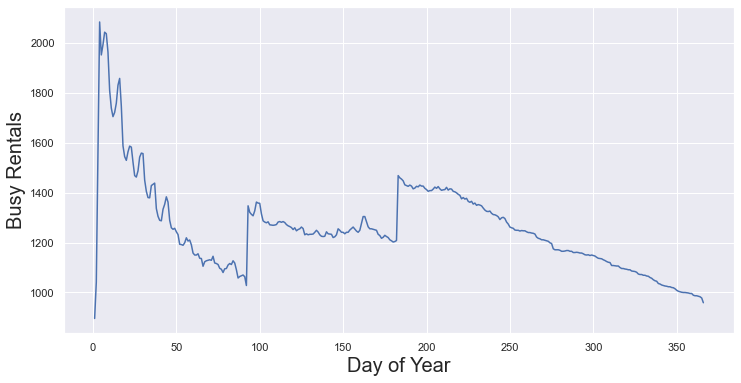

<Figure size 864x432 with 0 Axes>

In [9]:
# graph the "day of year" vs. "busy rentals" to observe the busy time in Seattle
sns.set_theme()
sns.set(rc={"figure.figsize":(12, 6)})
sns.lineplot(data=calendar,
                x='date',
                y='busy')
plt.xlabel('Day of Year', fontsize=20)
plt.ylabel("Busy Rentals", fontsize=20)
plt.show()
plt.clf()

### 2.2 Possible features affect the price of the Airbnb rentals

In [10]:
# select columns that interested in
listings = listings[['id', 'neighbourhood_group_cleansed', 'property_type', 'room_type',
                     'accommodates', 'bathrooms', 'beds', 'bedrooms', 'guests_included',
                     'availability_365', 'amenities', 'number_of_reviews', 'price']]

In [11]:
# rename some of the columns
listings.rename(columns = {'id':'listing_id',
                           'neighbourhood_group_cleansed':'Area',
                           'property_type':'Property',
                           'room_type':'Room'},
                inplace = True)
listings.head()

,listing_id,Area,Property,Room,accommodates,bathrooms,beds,bedrooms,guests_included,availability_365,amenities,number_of_reviews,price
0,241032,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,2,346,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",207,$85.00
1,953595,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,1,291,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",43,$150.00
2,3308979,Queen Anne,House,Entire home/apt,11,4.5,7.0,5.0,10,220,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",20,$975.00
3,7421966,Queen Anne,Apartment,Entire home/apt,3,1.0,2.0,0.0,1,143,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",0,$100.00
4,278830,Queen Anne,House,Entire home/apt,6,2.0,3.0,3.0,6,365,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",38,$450.00


In [12]:
# check if there are any nulls in columns
listings.isnull().sum()

listing_id            0
Area                  0
Property              1
Room                  0
accommodates          0
bathrooms            16
beds                  1
bedrooms              6
guests_included       0
availability_365      0
amenities             0
number_of_reviews     0
price                 0
dtype: int64

In [13]:
listings.dtypes

listing_id             int64
Area                  object
Property              object
Room                  object
accommodates           int64
bathrooms            float64
beds                 float64
bedrooms             float64
guests_included        int64
availability_365       int64
amenities             object
number_of_reviews      int64
price                 object
dtype: object

In [14]:
# drop the rows with nulls
listings.dropna(subset=['bathrooms', 'bedrooms', 'Property', 'beds'], inplace=True)
listings.reset_index(drop=True, inplace=True)

In [15]:
# remove the $ sign before the price and change the data type to float
listings['price'] = listings['price'].replace('[\$,]', '', regex=True).astype(float)

# calculate how many amenities in each listing
listings['amenities'] = listings['amenities'].str.count(',') + 1

array([[<AxesSubplot:title={'center':'listing_id'}>,
        <AxesSubplot:title={'center':'accommodates'}>,
        <AxesSubplot:title={'center':'bathrooms'}>],
       [<AxesSubplot:title={'center':'beds'}>,
        <AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'guests_included'}>],
       [<AxesSubplot:title={'center':'availability_365'}>,
        <AxesSubplot:title={'center':'amenities'}>,
        <AxesSubplot:title={'center':'number_of_reviews'}>],
       [<AxesSubplot:title={'center':'price'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

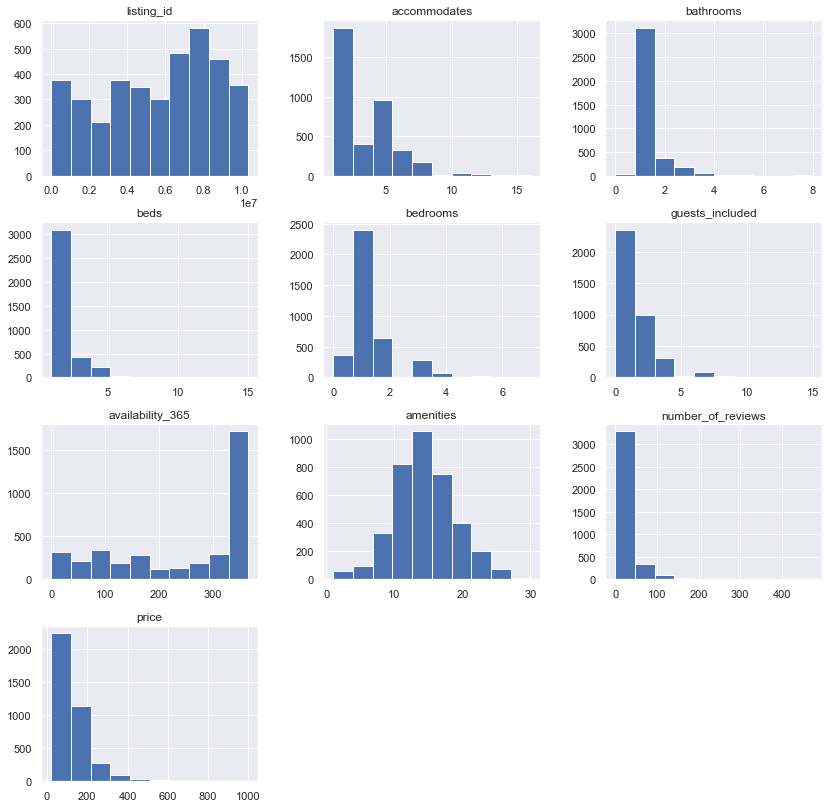

In [16]:
# display the numeric columns in histograms
listings.hist(figsize=(14,14))

In [17]:
# define a function that visualizes the categorical data
def plot_cat(column_name):
    sns.set_theme(style="whitegrid")
    cat = listings[[column_name]]
    sns.catplot(x=column_name, kind="count", data=cat, palette='ch:.25', aspect=2)
    plt.xlabel(column_name, fontsize=20)
    plt.ylabel("Count", fontsize=20)
    plt.xticks(rotation=45)
    plt.tick_params(labelsize=12)
    plt.show()
    plt.clf()

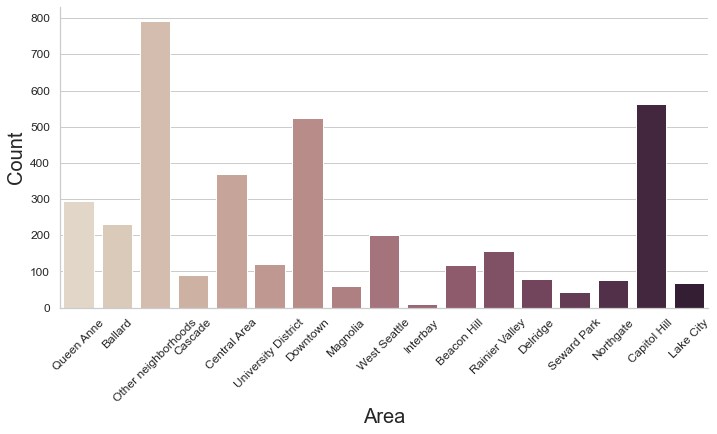

<Figure size 864x432 with 0 Axes>

In [18]:
plot_cat('Area')

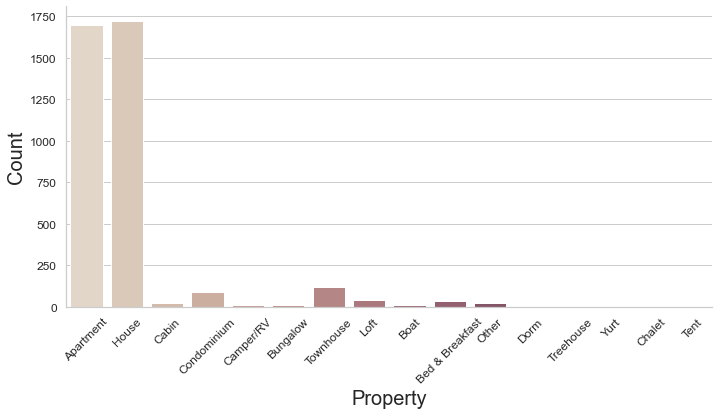

<Figure size 864x432 with 0 Axes>

In [19]:
plot_cat('Property')

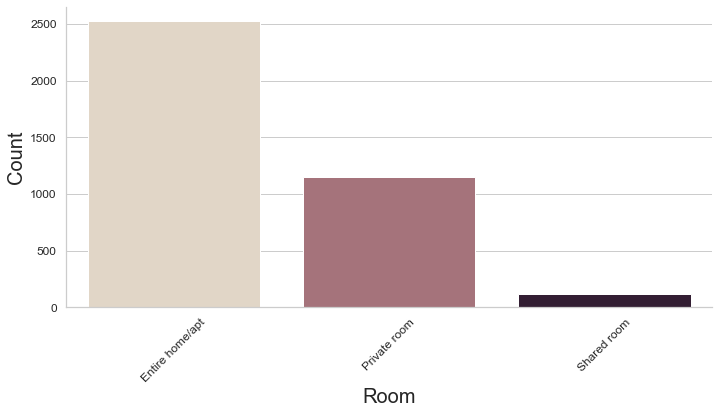

<Figure size 864x432 with 0 Axes>

In [20]:
plot_cat('Room')

### 2.3 Possible features affect the reviews of the rentals

In [21]:
reviews = reviews[['listing_id', 'comments']]
reviews.head()

,listing_id,comments
0,7202016,Cute and cozy place. Perfect location to every...
1,7202016,Kelly has a great room in a very central locat...
2,7202016,"Very spacious apartment, and in a great neighb..."
3,7202016,Close to Seattle Center and all it has to offe...
4,7202016,Kelly was a great host and very accommodating ...


In [22]:
reviews.isnull().sum()

listing_id     0
comments      18
dtype: int64

In [23]:
reviews.dropna(inplace=True)
reviews.reset_index(drop=True, inplace=True)

In [24]:
# run the following code once to download the resources needed for nltk:
# nltk.download('vader_lexicon')

# initiate sentiment intensity analyzer
analyzer = SentimentIntensityAnalyzer()

# compute the compound score of all comments
reviews['mean_review_score'] = [analyzer.polarity_scores(x)['compound'] for x in reviews['comments']]

# scale the score to make it easier to observe
reviews['mean_review_score'] = reviews['mean_review_score'] * 100

In [25]:
# groupby id and calculate the mean review score
reviews = reviews[['listing_id', 'mean_review_score']].groupby('listing_id').mean().reset_index()

In [26]:
# combine the reviews and listings data together
merged_reviews = reviews.merge(listings, how='inner', on='listing_id')
merged_reviews.head()

,listing_id,mean_review_score,Area,Property,Room,accommodates,bathrooms,beds,bedrooms,guests_included,availability_365,amenities,number_of_reviews,price
0,4291,77.826000,Other neighborhoods,House,Private room,2,1.0,1.0,1.0,1,365,12,35,82.0
1,5682,88.736419,Delridge,Apartment,Entire home/apt,2,1.0,1.0,1.0,1,309,15,297,48.0
2,6606,91.387692,Other neighborhoods,Apartment,Entire home/apt,2,1.0,1.0,1.0,2,365,12,52,90.0
3,7369,90.406000,Capitol Hill,Condominium,Entire home/apt,2,1.0,1.0,1.0,1,53,15,40,85.0
4,9419,90.284937,Other neighborhoods,House,Private room,2,3.0,1.0,1.0,1,365,13,79,90.0


In [27]:
# define a function to draw the graph
def plot_vs_review_score(column_name):
    df = merged_reviews[[column_name, 'mean_review_score']].groupby(column_name).mean().reset_index()
    if merged_reviews[column_name].dtype == 'object':
        df.sort_values(by=['mean_review_score'], ascending=False, inplace=True)
        sns.set_theme(style="whitegrid")
        sns.catplot(data=df,
                    x=df.columns[0],
                    y=df.columns[1],
                    kind="bar",
                    palette='ch:.25',
                    aspect=2)
        plt.xticks(rotation=45)
        plt.tick_params(labelsize=12)
    else:
        sns.set_theme()
        sns.set(rc={"figure.figsize":(12, 6)})
        sns.scatterplot(data=df,
                        x=df.columns[0],
                        y=df.columns[1])
    plt.xlabel(df.columns[0], fontsize=20)
    plt.ylabel("Mean Review Score", fontsize=20)
    plt.show()
    plt.clf()

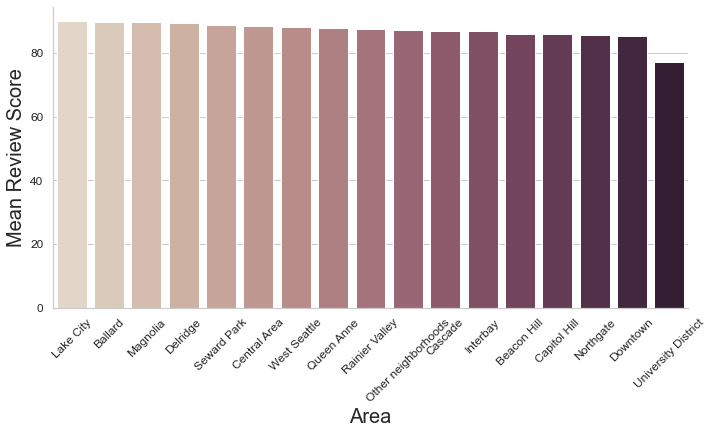

<Figure size 864x432 with 0 Axes>

In [28]:
plot_vs_review_score('Area')

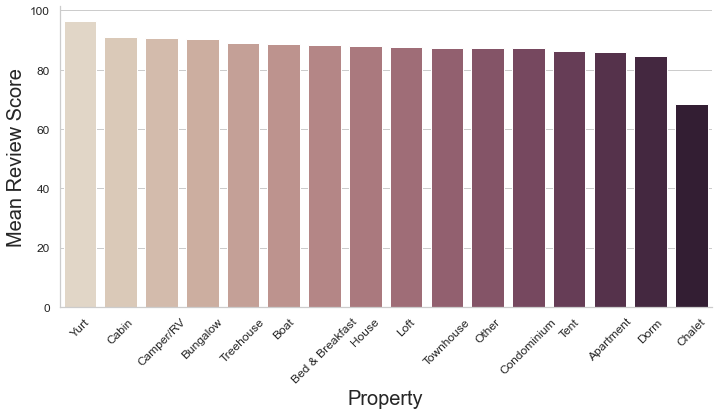

<Figure size 864x432 with 0 Axes>

In [29]:
plot_vs_review_score('Property')

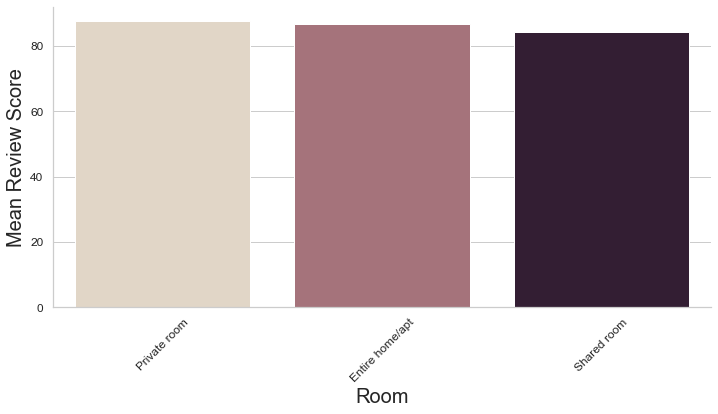

<Figure size 864x432 with 0 Axes>

In [30]:
plot_vs_review_score('Room')

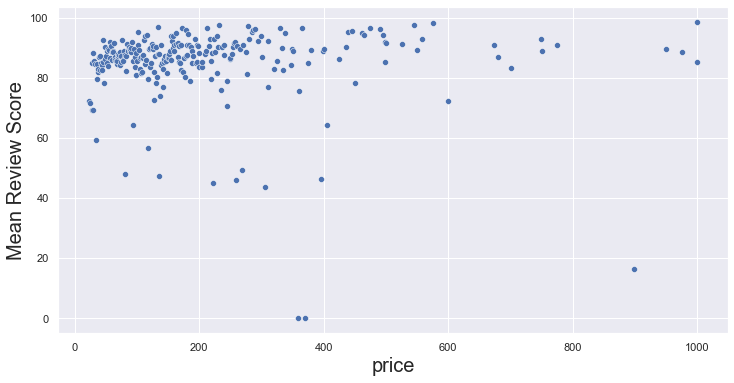

<Figure size 864x432 with 0 Axes>

In [31]:
plot_vs_review_score('price')

## 3. Data Preparation and Modelling

In [32]:
# import libraries for modeling
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [33]:
# define a function to process data
# returns a dataframe
def prepare_data(dependent_variable):
    
    # make a copy of data
    df = merged_reviews.drop(columns=['listing_id']).copy()
    
    # listing the numerical columns
    num_list = df.select_dtypes(include=np.number).columns.tolist()
    
    # remove the dependent variable from the list
    num_list.remove(dependent_variable)
    
    # normalizing numerical columns by using z-scores
    df[num_list] = StandardScaler().fit_transform(df[num_list])
    
    # one-hot encoding for categorical columns
    df = pd.get_dummies(df, columns=['Area', 'Property', 'Room'])
    
    return df


# function to model the data using linear regression
# returns test data, predicted data, feature names, and the model
def train_model(dependent_variable):
    
    df = prepare_data(dependent_variable)
    
    # split data into training and testing sets
    X = df.drop(columns=[dependent_variable])
    y = df[dependent_variable]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)
    
    # train a linear regression model
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    # make predictions using the test data
    y_pred = lr.predict(X_test)
    
    return (y_test, y_pred, X.columns.tolist(), lr)

In [34]:
# model: vs. price
price_model = train_model('price')

# model: vs. mean_review_score
mean_review_score_model = train_model('mean_review_score')

## 4. Evaluation

In [35]:
# print the r2 score, mean absolute error, and mean squared error
def evaluate_model(model):
    print(f"R2 Score: {round(r2_score(model[0], model[1]), 2)}")
    print(f"Mean absolute error: {round(mean_absolute_error(model[0], model[1]), 2)}")
    print(f"Mean squared error: {round(mean_squared_error(model[0], model[1]), 2)}")


# combine the coef. and feature names in one dataframe with descending order
# returns a dataframe
def list_importance(model):
    # importance as correlation coefficient
    importance = model[3].coef_
    col_name = model[2]
    
    # put the coef. in dictionary; column names as key and coef. as value
    features = {}
    for i, v in enumerate(importance):
        features[col_name[i]] = round(v, 2)
    
    #sort the features in descending order and put them in dataframe
    result_features = pd.DataFrame(sorted(features.items(), key=lambda x:abs(x[1]), reverse=True))
    result_features.columns = ["Features", "Coefficient"]
    
    return result_features


# graph the top 10 important features
def graph_importance(model):
    df = list_importance(model)
    sns.set_theme(style="whitegrid")
    sns.catplot(x="Coefficient",
                y="Features",
                kind='bar',
                data=df[:10],
                orient='h',
                palette='ch:.25',
                aspect=2,
                height=8)
    plt.show()
    plt.clf()

In [36]:
evaluate_model(price_model)

R2 Score: 0.54
Mean absolute error: 34.87
Mean squared error: 3939.58


In [37]:
evaluate_model(mean_review_score_model)

R2 Score: 0.03
Mean absolute error: 7.79
Mean squared error: 156.12


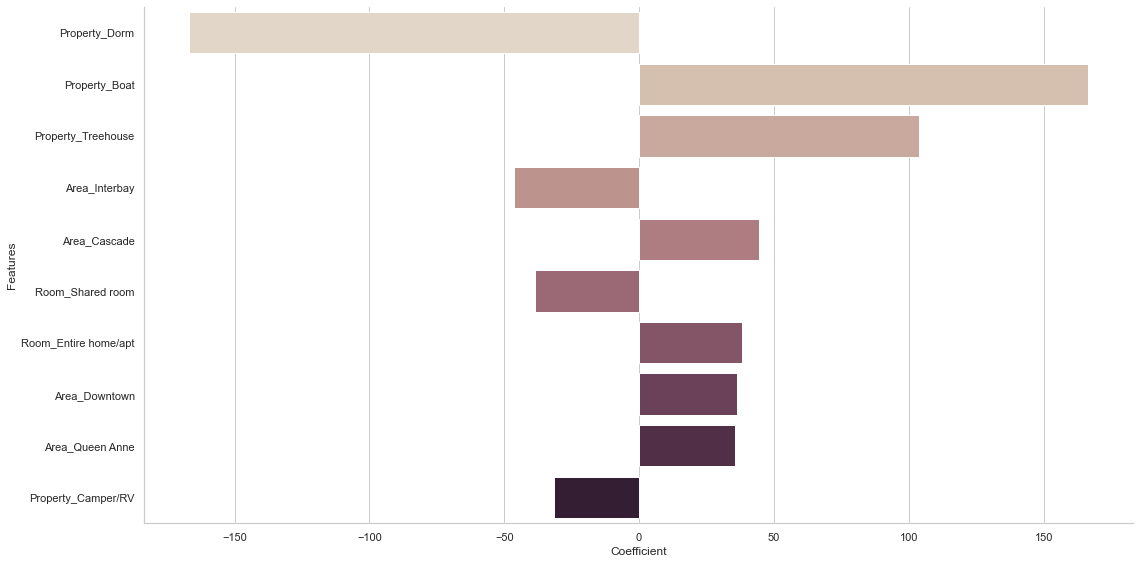

<Figure size 864x432 with 0 Axes>

In [38]:
graph_importance(price_model)

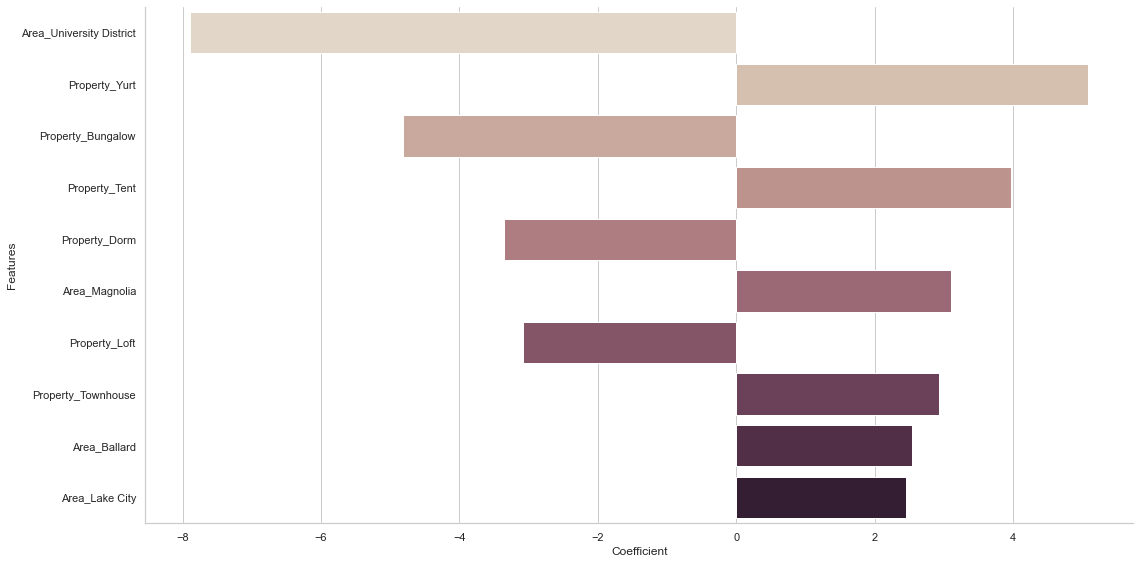

<Figure size 864x432 with 0 Axes>

In [39]:
graph_importance(mean_review_score_model)